# View Extracted Pixel Exposure Sky background and noise  from Calexp and CalexpBackground and CCD Visits for Auxtel

- Just read pandas dataframe and show plots

- author Sylvie Dagoret-Campagne
- creation date 2024-05-17
- last update 2024-05-29 : Fit a straight line
- affiliation : IJCLab
- kernel : **w_2024_16**

``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399

``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time

from astropy.modeling import models, fitting

In [3]:
import matplotlib.dates as mdates
#month_locator = mdates.MonthLocator(interval=1)
#day_locator = mdates.DayLocator(interval=1)
#year_month_formatter = mdates.DateFormatter("%Y-%m") 

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

In [4]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


In [5]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [6]:
fdir = get_data_dir()
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'auxtel')

In [7]:
import sys
sys.path.append('../lib')
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [8]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2024_17/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [9]:
all_Sigb = {}
all_SigbInv = {}
for index,f in enumerate(filter_tagnames): 
    wl = pc.bandpass_inst[f].wavelen
    tr = pc.bandpass_inst[f].sb
    Sigb = np.trapz(tr/wl,wl)
    all_Sigb[f] = Sigb 
    all_SigbInv[f] = 1/Sigb 

In [10]:
pd.DataFrame(all_Sigb, index=['Sigmab']).round(4)

,u,g,r,i,z,y
Sigmab,0.0055,0.1961,0.1434,0.1481,0.085,0.03


In [11]:
pd.DataFrame(all_SigbInv, index=['SigmabInv']).round(4)

,u,g,r,i,z,y
SigmabInv,181.9853,5.1002,6.9735,6.7518,11.7614,33.2995


### For fitting

In [12]:
model = models.Linear1D()
fitter = fitting.LinearLSQFitter() 

In [13]:
from lsst.daf.butler import Butler
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
#collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED
collections = [collection]
collectionn = collection
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_photocalib = f"ccdVisittractpatch_{collectionStr}_calexpinfo.csv"
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"

suptitle = collectionStr + f" inst = {instrument} "

In [14]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4


## Read inputs

### Access CCD visit table

In [15]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069']


In [16]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [17]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [18]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
40919696896    20230511
40919697408    20230511
40919698432    20230511
40919698944    20230511
40919699200    20230511
                 ...   
43729938688    20240410
43729938944    20240410
43729939200    20240410
43729939456    20240410
43729939712    20240410
Name: nightObs, Length: 5397, dtype: int64

In [19]:
# get time
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

In [20]:
# get airmass
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

In [21]:
# select the missing quantities (the time)
ccd_visit_table_subset = ccd_visit_table[["Time","obsStart"]]

### Read pandas dataframe containing the tract-patch decomposition of visits

In [22]:

# need the visit file because observation date is missing
file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)
df1 = pd.read_csv(file_selected_visits,index_col=0)

### Read the dataframe with the extracted parameters from calexp,calexpBackground

In [23]:
df = pd.read_csv(fn_ccdVisit_photocalib,index_col=0)

In [24]:
df

,idx,visitId,ccdVisitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,...,std_bkg_m,sigMad_bkg_m,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m
0,0,2023051100262,40919696896,r,0,27.691925,1.823818,11.193549,7.856800,30.0,...,0.248366,0.225585,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486
1,1,2023051100264,40919697408,i,0,27.854723,1.762794,28.073927,8.586373,30.0,...,0.179049,0.156368,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220
2,2,2023051100268,40919698432,r,0,27.773005,1.721301,10.700970,7.854424,30.0,...,0.209981,0.178780,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189
3,3,2023051100270,40919698944,i,0,27.859426,1.695170,23.952974,8.440454,30.0,...,0.153219,0.113119,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426
4,4,2023051100271,40919699200,i,0,27.846539,1.677014,23.321407,8.416399,30.0,...,0.192677,0.186060,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5392,5392,2024041000489,43729938688,y,0,26.041475,1.511427,15.985236,8.106778,30.0,...,0.300461,0.257039,17.008020,16.292530,38.432150,8.241574,16.110833,16.098310,8.194294,8.173982
5393,5393,2024041000490,43729938944,g,0,27.940567,1.520921,3.106054,7.474746,30.0,...,0.206186,0.178378,4.521265,3.421193,53.836727,7.590711,3.247030,3.252452,7.554529,7.511768
5394,5394,2024041000491,43729939200,r,0,27.792534,1.525628,6.620466,7.680325,30.0,...,0.397544,0.270320,8.553000,7.022195,79.708600,7.808471,6.775610,6.773452,7.748752,7.694970
5395,5395,2024041000492,43729939456,z,0,27.290150,1.530404,18.576742,8.271068,30.0,...,0.426516,0.321347,20.611366,19.032433,89.627600,8.429878,18.757024,18.734940,8.316185,8.294496


In [25]:
df.set_index("ccdVisitId",inplace=True)

In [26]:
df

,idx,visitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,photocalib_m,...,std_bkg_m,sigMad_bkg_m,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
40919696896,0,2023051100262,r,0,27.691925,1.823818,11.193549,7.856800,30.0,30.490464,...,0.248366,0.225585,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486
40919697408,1,2023051100264,i,0,27.854723,1.762794,28.073927,8.586373,30.0,25.507239,...,0.179049,0.156368,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220
40919698432,2,2023051100268,r,0,27.773005,1.721301,10.700970,7.854424,30.0,27.956394,...,0.209981,0.178780,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189
40919698944,3,2023051100270,i,0,27.859426,1.695170,23.952974,8.440454,30.0,26.273077,...,0.153219,0.113119,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426
40919699200,4,2023051100271,i,0,27.846539,1.677014,23.321407,8.416399,30.0,26.568090,...,0.192677,0.186060,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43729938688,5392,2024041000489,y,0,26.041475,1.511427,15.985236,8.106778,30.0,125.915622,...,0.300461,0.257039,17.008020,16.292530,38.432150,8.241574,16.110833,16.098310,8.194294,8.173982
43729938944,5393,2024041000490,g,0,27.940567,1.520921,3.106054,7.474746,30.0,23.458452,...,0.206186,0.178378,4.521265,3.421193,53.836727,7.590711,3.247030,3.252452,7.554529,7.511768
43729939200,5394,2024041000491,r,0,27.792534,1.525628,6.620466,7.680325,30.0,27.368571,...,0.397544,0.270320,8.553000,7.022195,79.708600,7.808471,6.775610,6.773452,7.748752,7.694970


## Add to the main dataframe df, the obstime found in ccd_visit_table

In [27]:
df = df.join(ccd_visit_table_subset)

In [28]:
df

,idx,visitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,photocalib_m,...,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m,Time,obsStart
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
40919696896,0,2023051100262,r,0,27.691925,1.823818,11.193549,7.856800,30.0,30.490464,...,13.167816,11.390819,266.133000,7.994249,11.287793,11.287639,7.959124,7.940486,2023-05-12 01:08:41.302993,2023-05-12 01:08:41.302993
40919697408,1,2023051100264,i,0,27.854723,1.762794,28.073927,8.586373,30.0,25.507239,...,38.809303,28.262280,1188.283700,8.728232,28.132761,28.130495,8.683864,8.655220,2023-05-12 01:14:49.912000,2023-05-12 01:14:49.912000
40919698432,2,2023051100268,r,0,27.773005,1.721301,10.700970,7.854424,30.0,27.956394,...,12.794616,10.863235,288.811520,7.990491,10.761060,10.754449,7.955056,7.935189,2023-05-12 01:19:24.311494,2023-05-12 01:19:24.311494
40919698944,3,2023051100270,i,0,27.859426,1.695170,23.952974,8.440454,30.0,26.273077,...,22.809006,24.114464,353.772100,8.576545,24.015178,23.997007,8.539144,8.510426,2023-05-12 01:22:21.150002,2023-05-12 01:22:21.150002
40919699200,4,2023051100271,i,0,27.846539,1.677014,23.321407,8.416399,30.0,26.568090,...,25.825996,23.512068,298.147800,8.556888,23.397298,23.379817,8.509870,8.486023,2023-05-12 01:24:32.058502,2023-05-12 01:24:32.058502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43729938688,5392,2024041000489,y,0,26.041475,1.511427,15.985236,8.106778,30.0,125.915622,...,17.008020,16.292530,38.432150,8.241574,16.110833,16.098310,8.194294,8.173982,2024-04-11 03:28:33.433496,2024-04-11 03:28:33.433496
43729938944,5393,2024041000490,g,0,27.940567,1.520921,3.106054,7.474746,30.0,23.458452,...,4.521265,3.421193,53.836727,7.590711,3.247030,3.252452,7.554529,7.511768,2024-04-11 03:30:12.763000,2024-04-11 03:30:12.763000
43729939200,5394,2024041000491,r,0,27.792534,1.525628,6.620466,7.680325,30.0,27.368571,...,8.553000,7.022195,79.708600,7.808471,6.775610,6.773452,7.748752,7.694970,2024-04-11 03:30:59.394501,2024-04-11 03:30:59.394501


## Formula to bear in mind

$$
\left\{
\begin{array}{ccc} \\
m_{AB}  & = & -2.5\cdot \log_{10}(ADU) + m(ZP) \\ \\
F(Jy) & = & F_{AB}^{ref}(Jy) \cdot 10^{-0.4\cdot m(ZP)}\cdot ADU
\end{array}
\right.
$$

## Additionnal processing

$$
ZP(CCDvisit) = ZP(magzero_calexp) + 2.5\log_{10} \Delta t 
$$

- this shows that $ZP(CCDvisit)$ is relative to ADU while $ZP(magzero\_calexp)$ is relative to $ADU/\Delta t$.

In [29]:
df["magzero_dt"] = df["magzero"].apply(lambda x : x+2.5*np.log10(30))
df["zeroPoint_diff"] = df["zeroPoint"]-df["magzero_dt"]

### Add Sigma/N

In [30]:
df["sigmatoskybkg"] = df["sigMad_ce"]/df["med_bkg"]
df["sigmatoskybkg_max"] = df["med_bkg"].apply(lambda x : 1/np.sqrt(x))

In [31]:
df.columns

Index(['idx', 'visitId', 'band', 'detector', 'zeroPoint', 'airmass', 'skyBg',
       'skyNoise', 'expTime', 'photocalib_m', 'photocalib_e', 'magzero',
       'magzero_rms', 'magzero_nobj', 'bgmean', 'bgvar', 'mu_ce', 'med_ce',
       'std_ce', 'sigMad_ce', 'mu_ce_m', 'med_ce_m', 'std_ce_m', 'sigMad_ce_m',
       'mu_bkg', 'med_bkg', 'std_bkg', 'sigMad_bkg', 'mu_bkg_m', 'med_bkg_m',
       'std_bkg_m', 'sigMad_bkg_m', 'mu_pisr', 'med_pisr', 'std_pisr',
       'sigMad_pisr', 'mu_pisr_m', 'med_pisr_m', 'std_pisr_m', 'sigMad_pisr_m',
       'Time', 'obsStart', 'magzero_dt', 'zeroPoint_diff', 'sigmatoskybkg',
       'sigmatoskybkg_max'],
      dtype='object')

In [32]:
df["photocalib_mag"] = df["photocalib_m"].apply(convert_fluxtomag)

In [33]:
df["zeroPoint_photocalib_diff"] = df["zeroPoint"] - df["photocalib_mag"]
df["magzerodt_photocalib_diff"] = df["magzero_dt"] - df["photocalib_mag"]

## Split the dataframe in bands

In [34]:
df_g = df[df["band"] == 'g']
df_r = df[df["band"] == 'r']
df_i = df[df["band"] == 'i']
df_z = df[df["band"] == 'z']
df_y = df[df["band"] == 'y']

## Sky Background

In [35]:
sigmaNfit = {}
slopefit = {}
interceptfit = {}

### Sky Background in g band

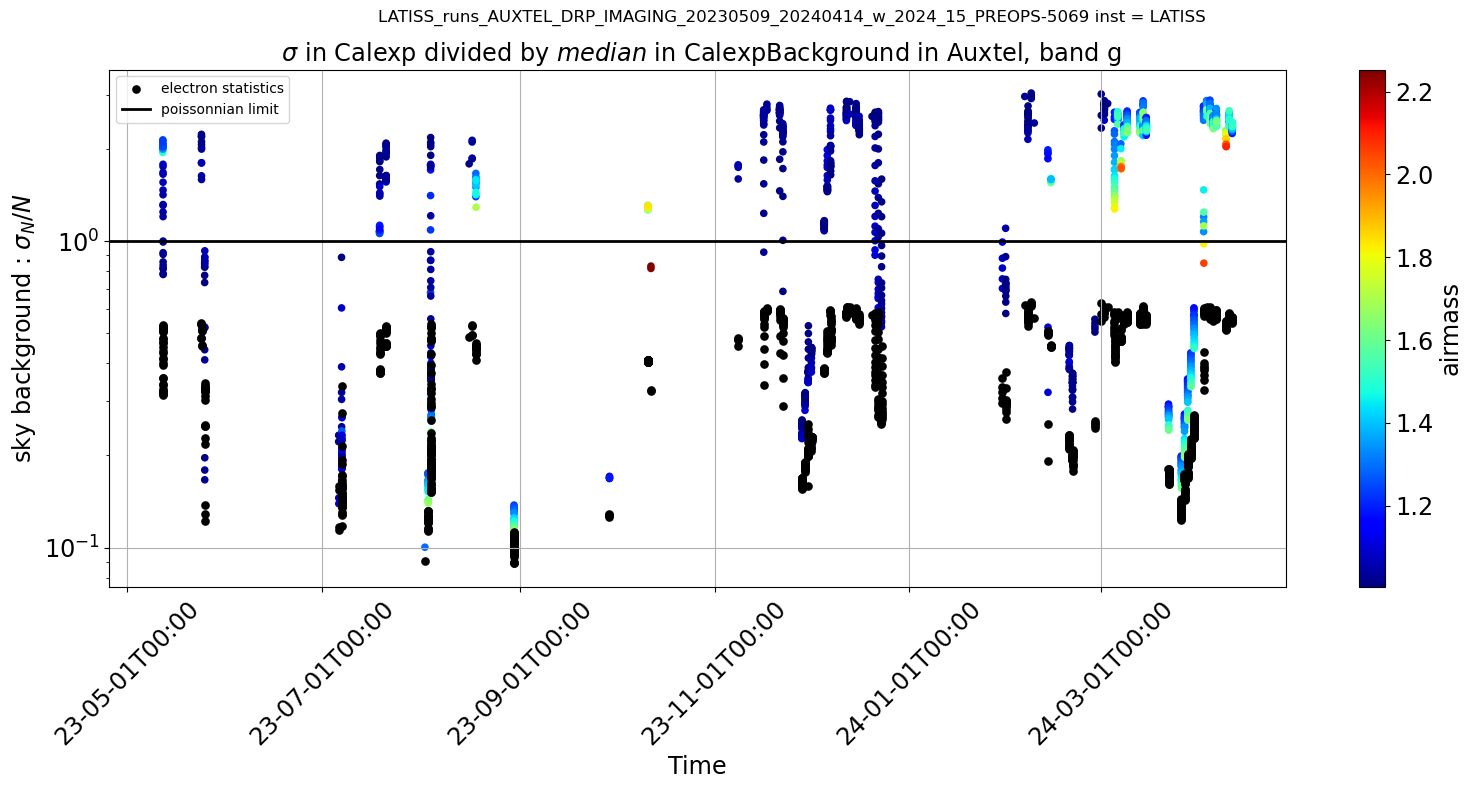

In [36]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band g"
df_g.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_g.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics",grid=True,lw=4)

ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="k",label="poissonnian limit")
ax.legend()
ax.set_ylabel("sky background : $\sigma_N/N$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandG_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Make a straight line fit

- Poissonian Background
$$
\log_{10} \frac{\sigma}{M} = -0.5\log_{10} (g) - 0.5 \log_{10}(N_{ADU}) 
$$

- Electronic Noise $\sigma_N$

$$
\log_{10} \frac{\sigma}{M} = \log_{10} (\sigma_N) -  \log_{10}(N_{ADU}) 
$$

In [37]:
X = df_g["med_bkg"].apply(lambda x : np.log10(x))
Y1 = df_g["sigmatoskybkg"].apply(lambda x : np.log10(x))
Y2 = df_g["sigmatoskybkg_max"].apply(lambda x : np.log10(x))

In [38]:
len(X.values),len(Y1.values)

(1395, 1395)

In [39]:
best_fit1 = fitter(model, X.values, Y1.values)
best_fit2 = fitter(model, X.values, Y2.values)

In [40]:
best_fit1 

<Linear1D(slope=-0.91526019, intercept=0.83516976)>

In [41]:
sigmaN = np.power(10.,best_fit1.intercept.value) 
sigmaN 

6.841790242777759

In [42]:
sigmaNfit["g"] = sigmaN
slopefit["g"] = best_fit1.slope.value
interceptfit["g"] = best_fit1.intercept.value

In [43]:
best_fit2

<Linear1D(slope=-0.5, intercept=-0.)>

In [44]:
textstr = '\n'.join((
    r'Simple linear fit in (log,log) :',
    r'$slope = %.3f$' % (best_fit1.slope.value, ),
    r'$intercept = %.3f$' % (best_fit1.intercept.value, ),
    r'$\sigma_N = %.2f$ ADU' % (sigmaN, )))

In [45]:
textstr 

'Simple linear fit in (log,log) :\n$slope = -0.915$\n$intercept = 0.835$\n$\\sigma_N = 6.84$ ADU'

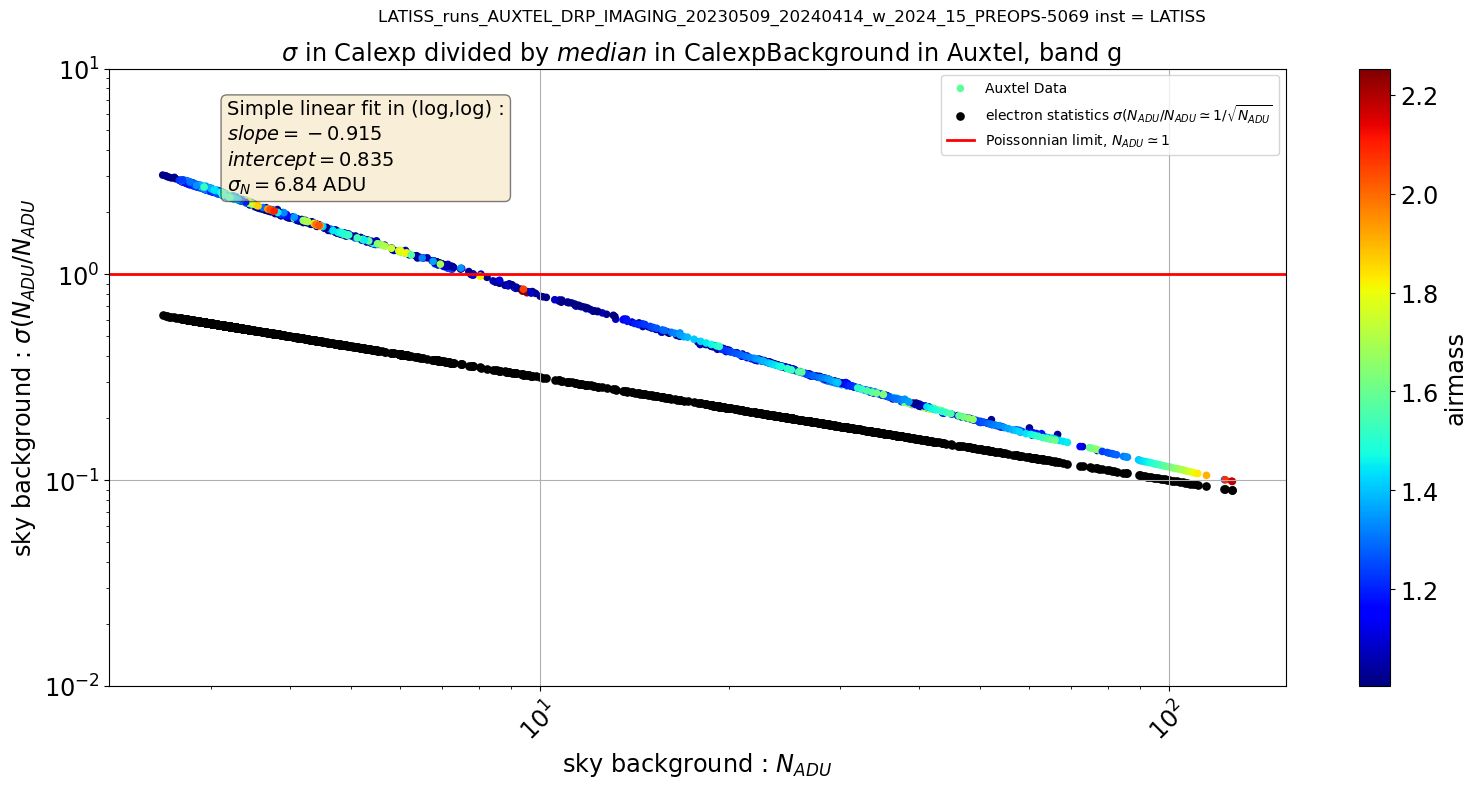

In [46]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band g"
df_g.plot.scatter(x="med_bkg",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",label="Auxtel Data",title=title,grid=True)
df_g.plot.scatter(x="med_bkg",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics $\sigma(N_{ADU}/N_{ADU} \simeq 1/\sqrt{N_{ADU}}$",grid=True,lw=4)

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(1.,lw=2,color="r",label="Poissonnian limit, $N_{ADU} \simeq 1$")
ax.legend()
ax.set_ylim(1e-2,10)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

ax.set_ylabel("sky background : $\sigma(N_{ADU}/N_{ADU}$")
ax.set_xlabel("sky background : $N_{ADU}$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandG_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in r band

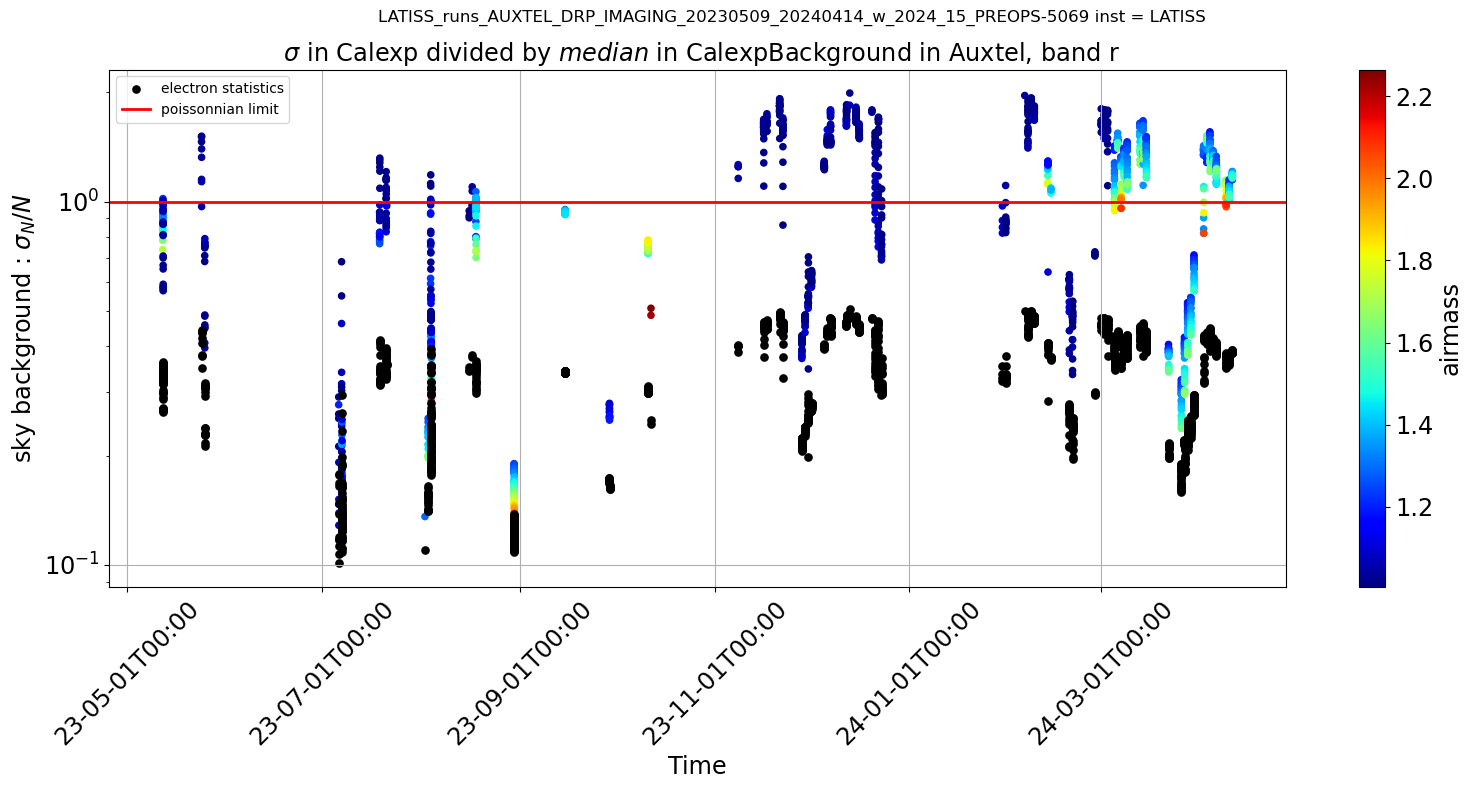

In [47]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band r"
df_r.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_r.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics",grid=True,lw=4)
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="r",label="poissonnian limit")
ax.legend()
ax.set_ylabel("sky background : $\sigma_N/N$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandR_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Fit a straight line

In [48]:
X = df_r["med_bkg"].apply(lambda x : np.log10(x))
Y1 = df_r["sigmatoskybkg"].apply(lambda x : np.log10(x))
Y2 = df_r["sigmatoskybkg_max"].apply(lambda x : np.log10(x))

In [49]:
best_fit1 = fitter(model, X.values, Y1.values)
best_fit2 = fitter(model, X.values, Y2.values)

In [50]:
best_fit1

<Linear1D(slope=-0.90460615, intercept=0.81868025)>

In [51]:
sigmaN = np.power(10.,best_fit1.intercept.value) 
sigmaN 

6.586887547953759

In [52]:
sigmaNfit["r"] = sigmaN
slopefit["r"] = best_fit1.slope.value
interceptfit["r"] = best_fit1.intercept.value

In [53]:
textstr = '\n'.join((
    r'Simple linear fit in (log,log) :',
    r'$slope = %.3f$' % (best_fit1.slope.value, ),
    r'$intercept = %.3f$' % (best_fit1.intercept.value, ),
    r'$\sigma_N = %.2f$ ADU' % (sigmaN, )))

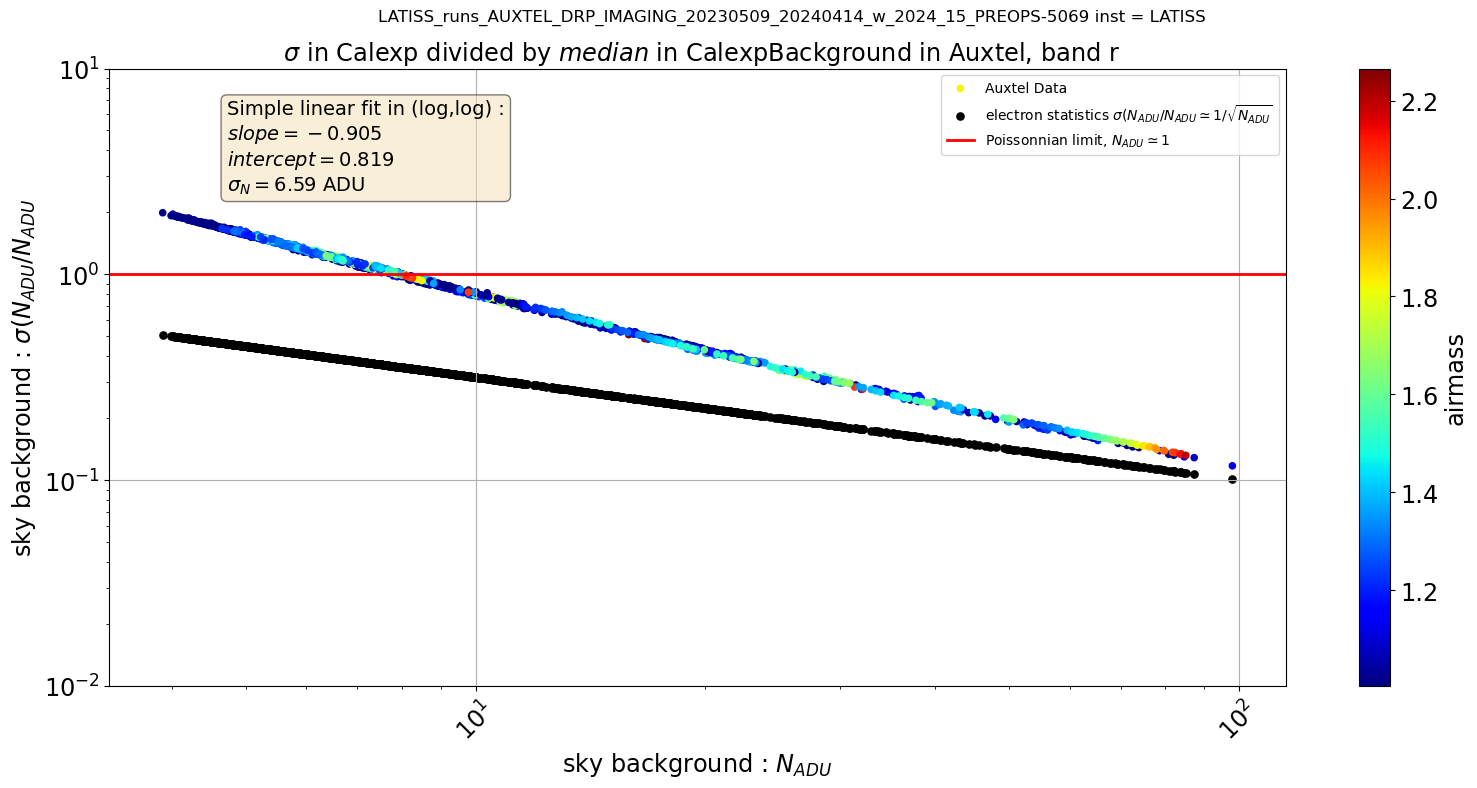

In [54]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band r"
df_r.plot.scatter(x="med_bkg",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",label="Auxtel Data",title=title,grid=True)
df_r.plot.scatter(x="med_bkg",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics $\sigma(N_{ADU}/N_{ADU} \simeq 1/\sqrt{N_{ADU}}$",grid=True,lw=4)

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(1.,lw=2,color="r",label="Poissonnian limit, $N_{ADU} \simeq 1$")
ax.legend()
ax.set_ylim(1e-2,10)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

ax.set_ylabel("sky background : $\sigma(N_{ADU}/N_{ADU}$")
ax.set_xlabel("sky background : $N_{ADU}$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandR_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in i band

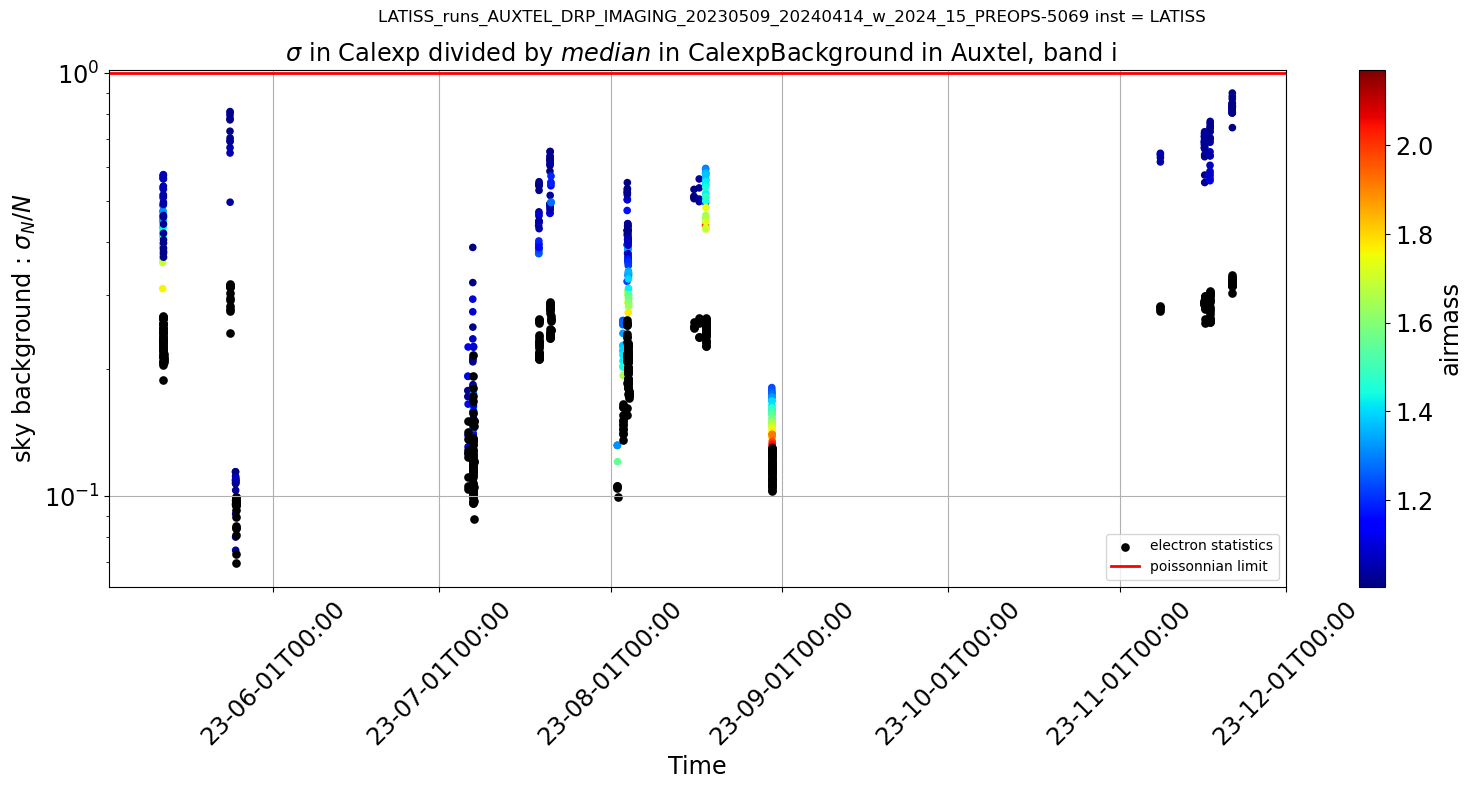

In [55]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band i"
df_i.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_i.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics",grid=True,lw=4)
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="r",label="poissonnian limit")
ax.legend()
plt.suptitle(suptitle)
ax.set_ylabel("sky background : $\sigma_N/N$")
figname = "calexp_sigmaNbyN_bandI_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Fit a straight line

In [56]:
X = df_i["med_bkg"].apply(lambda x : np.log10(x))
Y1 = df_i["sigmatoskybkg"].apply(lambda x : np.log10(x))
Y2 = df_i["sigmatoskybkg_max"].apply(lambda x : np.log10(x))

In [57]:
best_fit1 = fitter(model, X.values, Y1.values)
best_fit2 = fitter(model, X.values, Y2.values)

In [58]:
best_fit1 

<Linear1D(slope=-0.8226682, intercept=0.71021337)>

In [59]:
sigmaN = np.power(10.,best_fit1.intercept.value) 
sigmaN 

5.131134111885751

In [60]:
sigmaNfit["i"] = sigmaN
slopefit["i"] = best_fit1.slope.value
interceptfit["i"] = best_fit1.intercept.value

In [61]:
textstr = '\n'.join((
    r'Simple linear fit in (log,log) :',
    r'$slope = %.3f$' % (best_fit1.slope.value, ),
    r'$intercept = %.3f$' % (best_fit1.intercept.value, ),
    r'$\sigma_N = %.2f$ ADU' % (sigmaN, )))

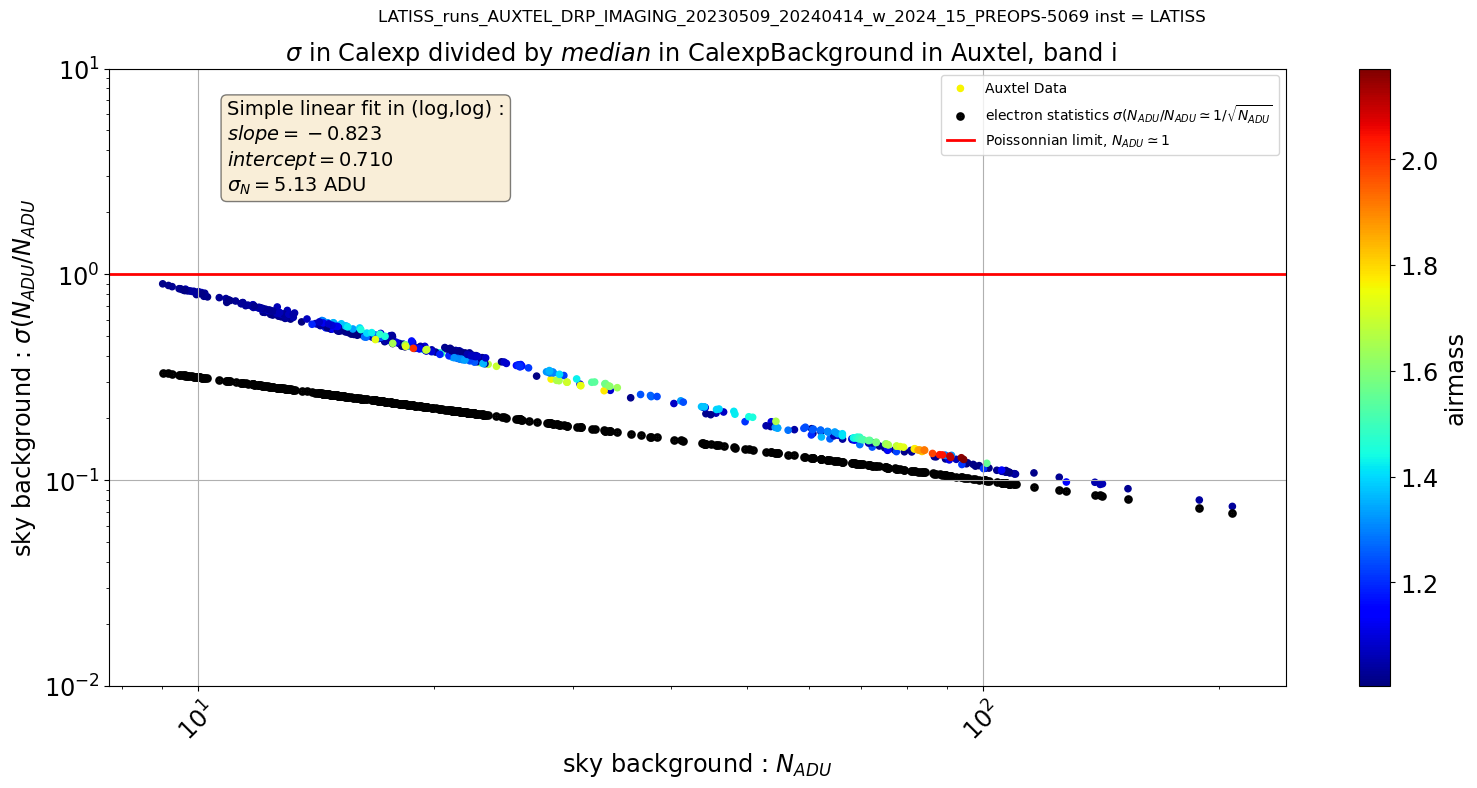

In [62]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band i"
df_i.plot.scatter(x="med_bkg",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",label="Auxtel Data",title=title,grid=True)
df_i.plot.scatter(x="med_bkg",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics $\sigma(N_{ADU}/N_{ADU} \simeq 1/\sqrt{N_{ADU}}$",grid=True,lw=4)

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(1.,lw=2,color="r",label="Poissonnian limit, $N_{ADU} \simeq 1$")
ax.legend()
ax.set_ylim(1e-2,10)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

ax.set_ylabel("sky background : $\sigma(N_{ADU}/N_{ADU}$")
ax.set_xlabel("sky background : $N_{ADU}$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandI_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in z band

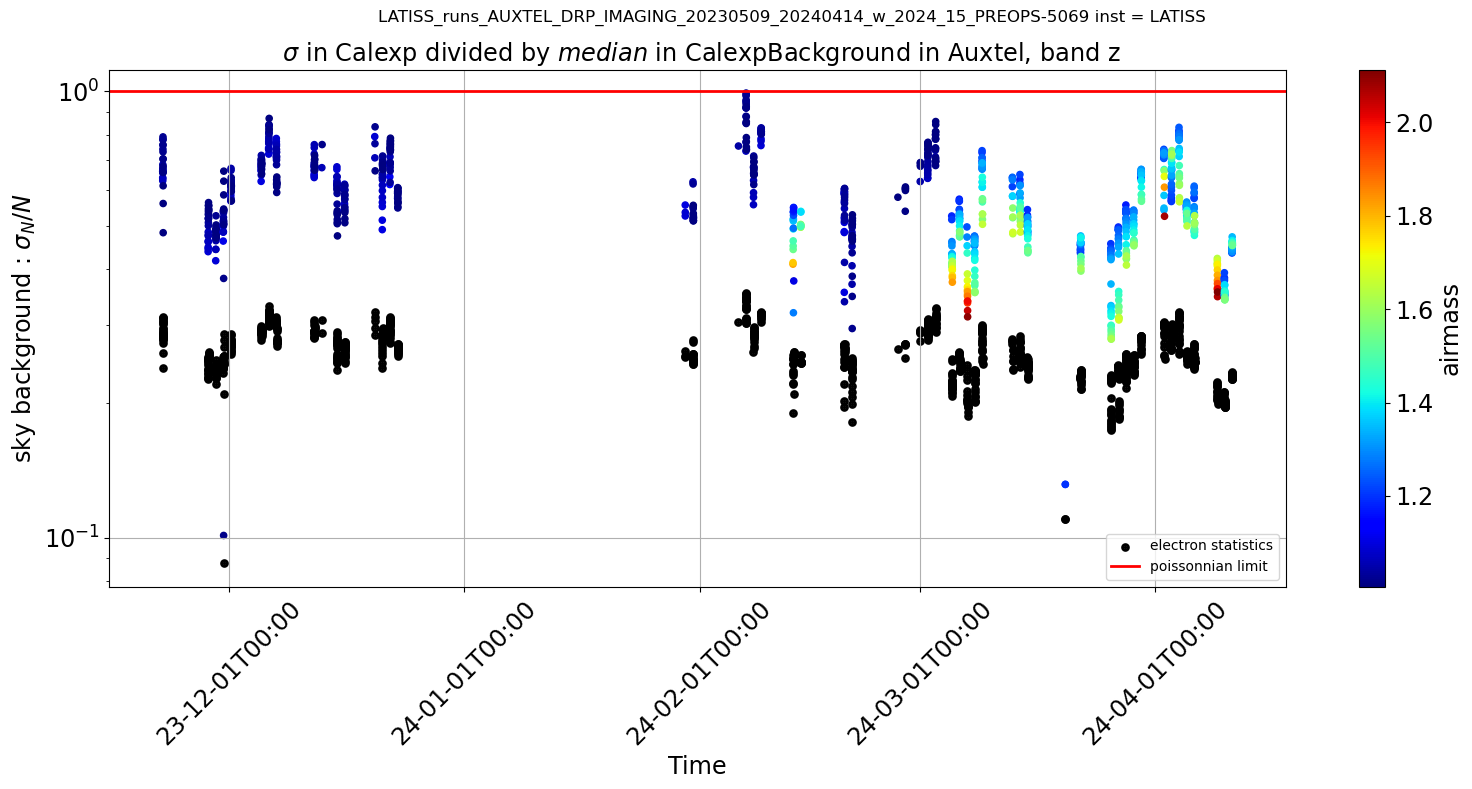

In [63]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band z"
df_z.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_z.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics",grid=True,lw=4)
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="r",label="poissonnian limit")
ax.legend()
ax.set_ylabel("sky background : $\sigma_N/N$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandZ_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Fit a straight line

In [64]:
X = df_z["med_bkg"].apply(lambda x : np.log10(x))
Y1 = df_z["sigmatoskybkg"].apply(lambda x : np.log10(x))
Y2 = df_z["sigmatoskybkg_max"].apply(lambda x : np.log10(x))

In [65]:
best_fit1 = fitter(model, X.values, Y1.values)
best_fit2 = fitter(model, X.values, Y2.values)

In [66]:
best_fit1 

<Linear1D(slope=-0.90299377, intercept=0.80604043)>

In [67]:
sigmaN = np.power(10.,best_fit1.intercept.value) 
sigmaN 

6.397943989719308

In [68]:
sigmaNfit["z"] = sigmaN
slopefit["z"] = best_fit1.slope.value
interceptfit["z"] = best_fit1.intercept.value

In [69]:
textstr = '\n'.join((
    r'Simple linear fit in (log,log) :',
    r'$slope = %.3f$' % (best_fit1.slope.value, ),
    r'$intercept = %.3f$' % (best_fit1.intercept.value, ),
    r'$\sigma_N = %.2f$ ADU' % (sigmaN, )))

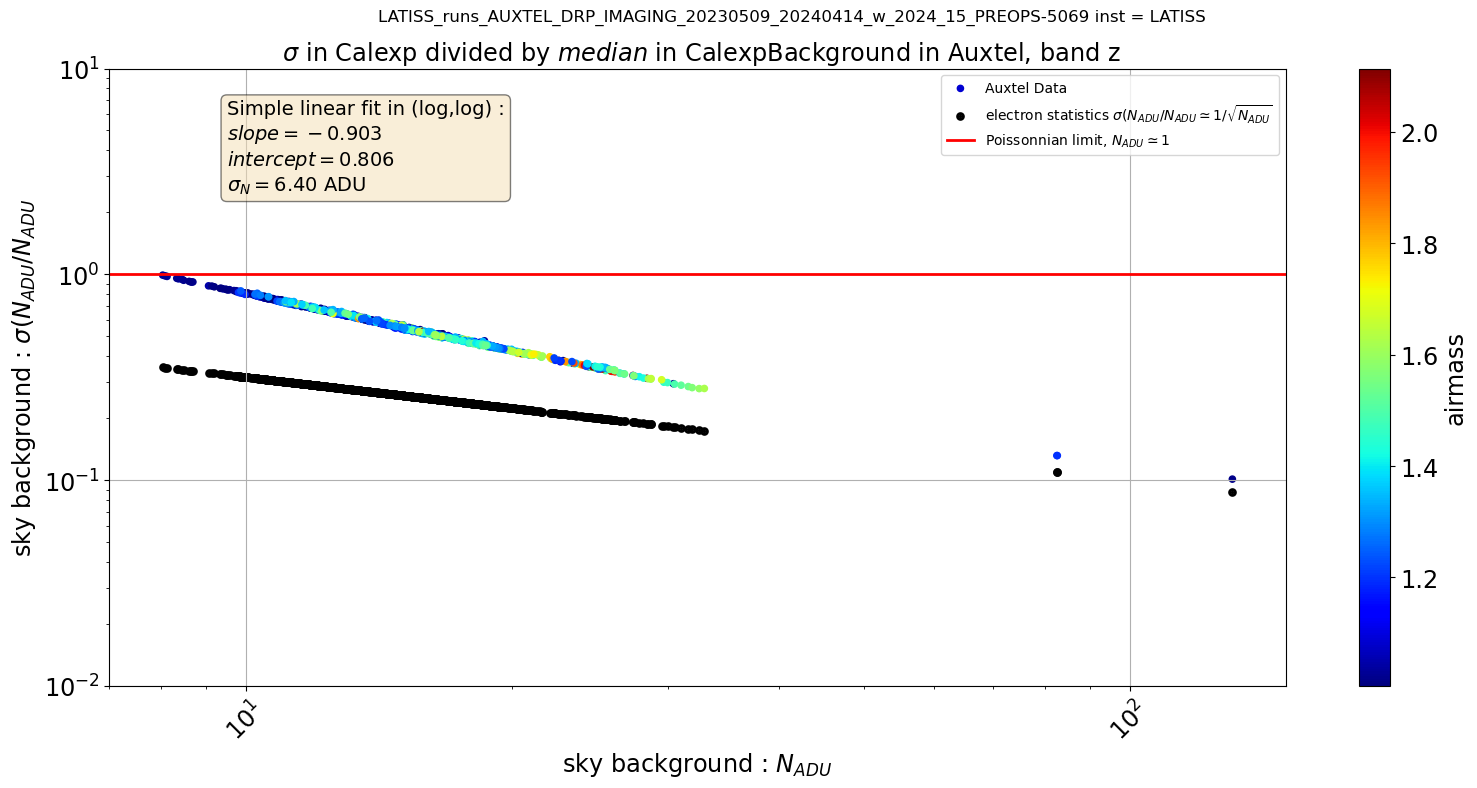

In [70]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band z"
df_z.plot.scatter(x="med_bkg",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",label="Auxtel Data",title=title,grid=True)
df_z.plot.scatter(x="med_bkg",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics $\sigma(N_{ADU}/N_{ADU} \simeq 1/\sqrt{N_{ADU}}$",grid=True,lw=4)

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(1.,lw=2,color="r",label="Poissonnian limit, $N_{ADU} \simeq 1$")
ax.legend()
ax.set_ylim(1e-2,10)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

ax.set_ylabel("sky background : $\sigma(N_{ADU}/N_{ADU}$")
ax.set_xlabel("sky background : $N_{ADU}$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandZ_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in y band

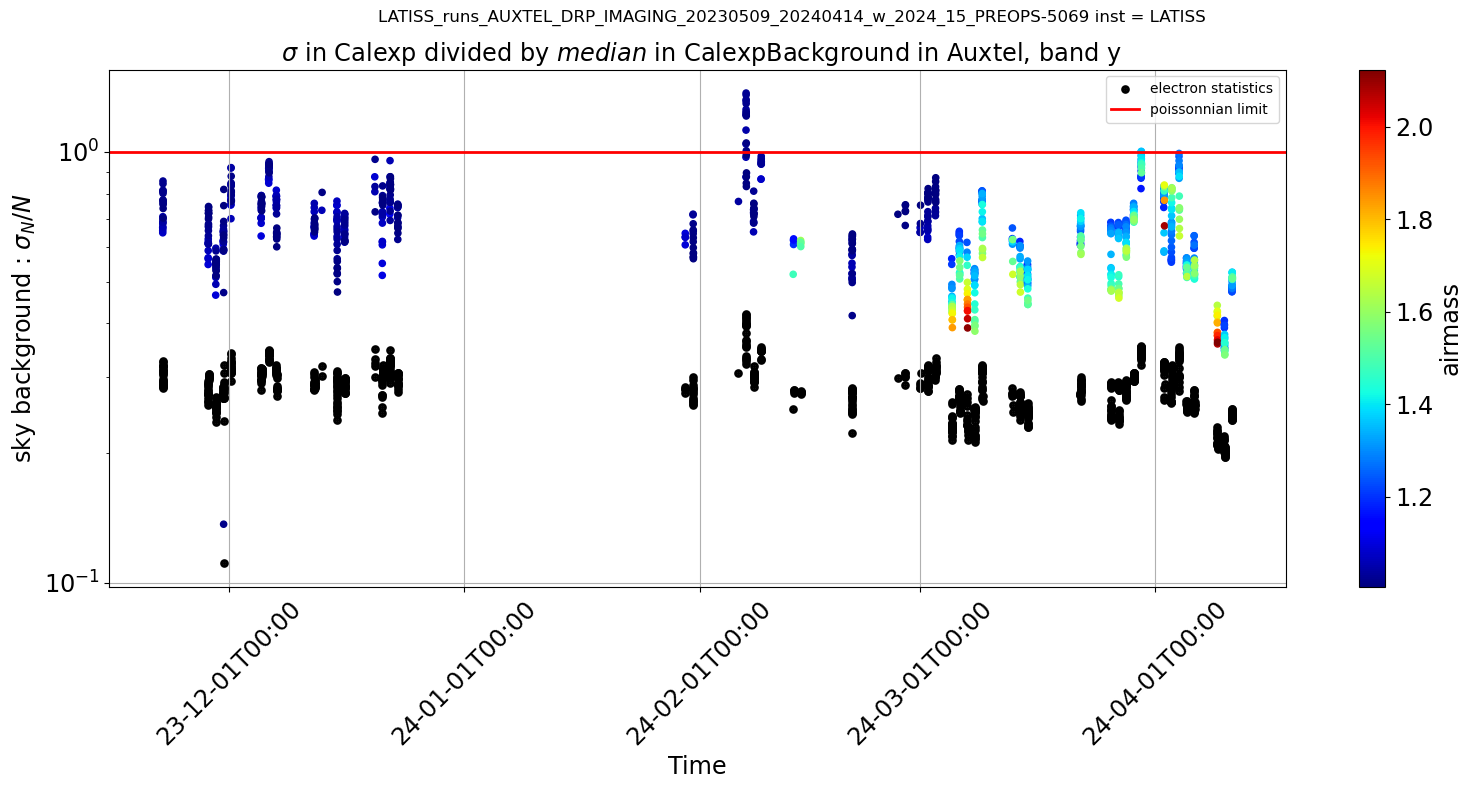

In [71]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band y"
df_y.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_y.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics",grid=True,lw=4)
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")
ax.axhline(1.,lw=2,color="r",label="poissonnian limit")
ax.legend()
ax.set_ylabel("sky background : $\sigma_N/N$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandY_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Fit a straight line

In [72]:
X = df_y["med_bkg"].apply(lambda x : np.log10(x))
Y1 = df_y["sigmatoskybkg"].apply(lambda x : np.log10(x))
Y2 = df_y["sigmatoskybkg_max"].apply(lambda x : np.log10(x))

In [73]:
best_fit1 = fitter(model, X.values, Y1.values)
best_fit2 = fitter(model, X.values, Y2.values)

In [74]:
best_fit1

<Linear1D(slope=-0.92188251, intercept=0.82428013)>

In [75]:
sigmaN = np.power(10.,best_fit1.intercept.value) 
sigmaN 

6.672370203840357

In [76]:
sigmaNfit["y"] = sigmaN
slopefit["y"] = best_fit1.slope.value
interceptfit["y"] = best_fit1.intercept.value

In [77]:
textstr = '\n'.join((
    r'Simple linear fit in (log,log) :',
    r'$slope = %.3f$' % (best_fit1.slope.value, ),
    r'$intercept = %.3f$' % (best_fit1.intercept.value, ),
    r'$\sigma_N = %.2f$ ADU' % (sigmaN, )))

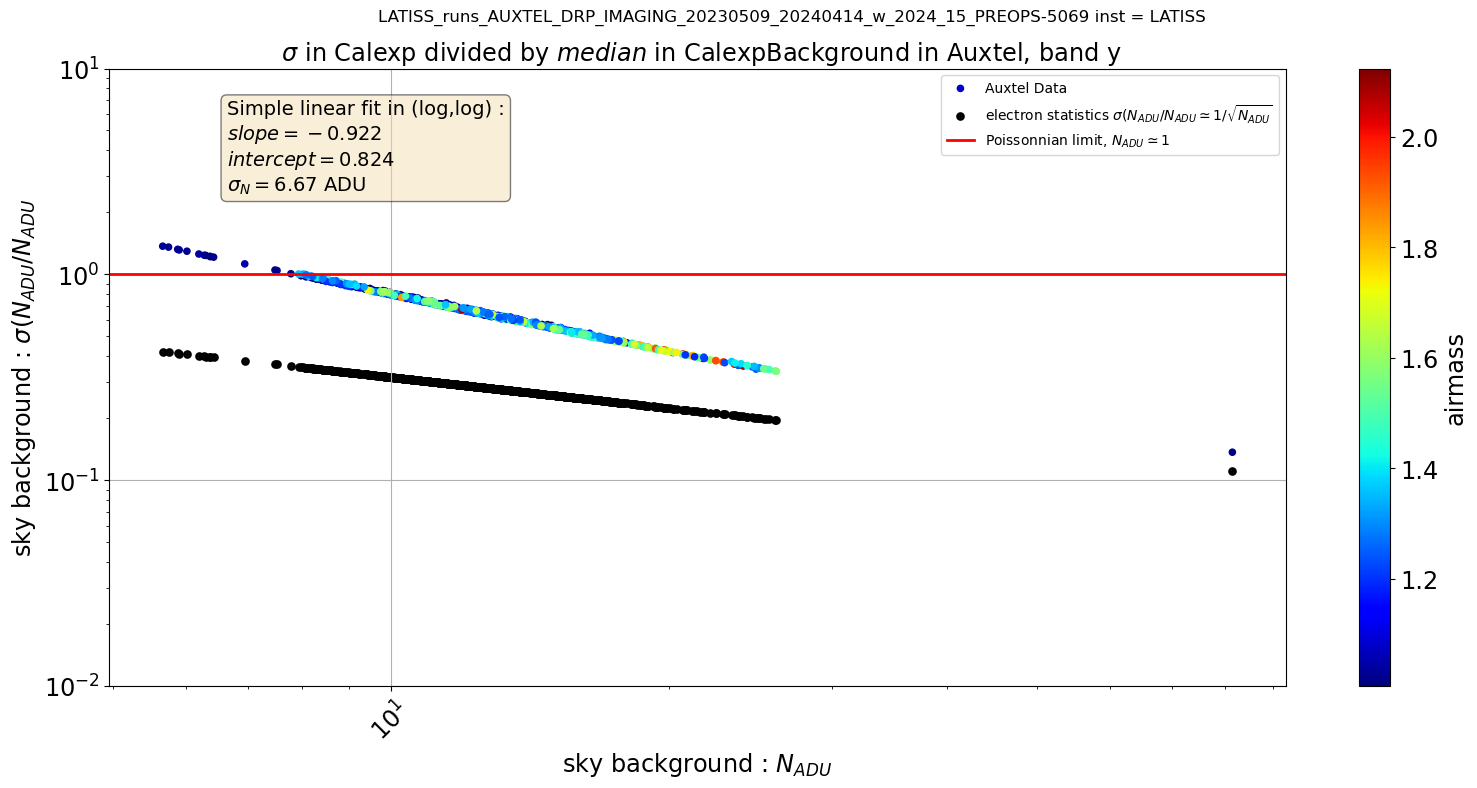

In [78]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in Auxtel, band y"
df_y.plot.scatter(x="med_bkg",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",label="Auxtel Data",title=title,grid=True)
df_y.plot.scatter(x="med_bkg",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics $\sigma(N_{ADU}/N_{ADU} \simeq 1/\sqrt{N_{ADU}}$",grid=True,lw=4)

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(1.,lw=2,color="r",label="Poissonnian limit, $N_{ADU} \simeq 1$")
ax.legend()
ax.set_ylim(1e-2,10)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

ax.set_ylabel("sky background : $\sigma(N_{ADU}/N_{ADU}$")
ax.set_xlabel("sky background : $N_{ADU}$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandY_Auxtel.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

## Summary

In [79]:
df1 = pd.DataFrame(slopefit, index=['slope']).round(4)
df2 = pd.DataFrame(interceptfit, index=['intercept']).round(4)
df3 = pd.DataFrame(sigmaNfit, index=['sigmaN']).round(4)

In [80]:
df_fit = pd.concat([df1,df2,df3])

In [81]:
df_fit

,g,r,i,z,y
slope,-0.9153,-0.9046,-0.8227,-0.9030,-0.9219
intercept,0.8352,0.8187,0.7102,0.8060,0.8243
sigmaN,6.8418,6.5869,5.1311,6.3979,6.6724


In [82]:
df_fit_t = df_fit.transpose() 
df_fit_t.index.name="band"
df_fit_t

,slope,intercept,sigmaN
band,,,
g,-0.9153,0.8352,6.8418
r,-0.9046,0.8187,6.5869
i,-0.8227,0.7102,5.1311
z,-0.9030,0.8060,6.3979
y,-0.9219,0.8243,6.6724


In [83]:
df_fit.transpose().to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>slope</th>\n      <th>intercept</th>\n      <th>sigmaN</th>\n    </tr>\n    <tr>\n      <th>band</th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>g</th>\n      <td>-0.9153</td>\n      <td>0.8352</td>\n      <td>6.8418</td>\n    </tr>\n    <tr>\n      <th>r</th>\n      <td>-0.9046</td>\n      <td>0.8187</td>\n      <td>6.5869</td>\n    </tr>\n    <tr>\n      <th>i</th>\n      <td>-0.8227</td>\n      <td>0.7102</td>\n      <td>5.1311</td>\n    </tr>\n    <tr>\n      <th>z</th>\n      <td>-0.9030</td>\n      <td>0.8060</td>\n      <td>6.3979</td>\n    </tr>\n    <tr>\n      <th>y</th>\n      <td>-0.9219</td>\n      <td>0.8243</td>\n      <td>6.6724</td>\n    </tr>\n  </tbody>\n</table>'

In [84]:
#df_fit.transpose().to_latex()